# Librerias

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import Image
import matplotlib.pyplot as plt
import functools

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Conv1D, Embedding,Reshape, Concatenate,BatchNormalization,GlobalMaxPooling1D,GlobalAveragePooling1D
from keras.layers.merge import Concatenate
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras import regularizers
from keras import metrics
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report


Using TensorFlow backend.


# Datos de entrenamiento

In [ ]:
data = pd.read_csv('D:/Visual Studio Code/HK 6/Data Mining/RASFF-predictions-dashboard/Copia csvs antiguos/splited_RASFF_DATA_16092019.csv', sep=';', 
                header=0, index_col = 0)
data = data.sample(frac = 1)
df = data
df

DATE_CASE  NOT_COUNTRY                                      PROD_CAT  \
0       2019-09-13       France   meat and meat products (other than poultry)   
1       2019-09-13      Denmark  cocoa and cocoa preparations, coffee and tea   
2       2019-09-13       Poland                                 confectionery   
3       2019-09-13        Spain                   cereals and bakery products   
4       2019-09-13        Spain                   cereals and bakery products   
...            ...          ...                                           ...   
141524  2004-01-05        Italy                         fruits and vegetables   
141525  2004-01-05     Portugal    molluscs and products thereof - (obsolete)   
141526  2004-01-05     Portugal    molluscs and products thereof - (obsolete)   
141527  2004-01-05  Netherlands                        fish and fish products   
141528  2004-01-05  Netherlands                        fish and fish products   

        TYPE RISK_DECISION                ACTION_TAKEN  \
0       food       serious               no stock left   
1       food       serious       recall from consumers   
2       food       serious       informing authorities   
3       food       serious  withdrawal from the market   
4       food       serious  withdrawal from the market   
...      ...           ...                         ...   
141524  food     undecided                               
141525  food     undecided                               
141526  food     undecided                               
141527  food     undecided                               
141528  food     undecided                               

                                   DISTRIBUTION_STAT  \
0             no distribution from notifying country   
1             no distribution from notifying country   
2       distribution restricted to notifying country   
3               distribution to non-member countries   
4               distribution to non-member countries   
...                                              ...   
141524                                                 
141525                                                 
141526                                                 
141527                                                 
141528                                                 

                                  HAZARDS_CAT COUNT_ORIGEN COUNT_DESTIN  \
0                  pathogenic micro-organisms      Romania       France   
1                      natural toxins (other)      Germany      Denmark   
2              food additives and flavourings      Croatia       Poland   
3                                      metals        Italy      Andorra   
4                                      metals        Italy        Spain   
...                                       ...          ...          ...   
141524  labelling absent/incomplete/incorrect        China                
141525             pathogenic micro-organisms       Brazil                
141526             pathogenic micro-organisms       Brazil                
141527        biological contaminants (other)    Indonesia      Belgium   
141528        biological contaminants (other)    Indonesia      Belgium   

       COUNT_CONCERN  
0            Belgium  
1                     
2                     
3            INFOSAN  
4            INFOSAN  
...              ...  
141524         Spain  
141525      Portugal  
141526         Spain  
141527   Netherlands  
141528         Spain  

[141529 rows x 11 columns]

# Pre-procesamiento basico

In [ ]:
df['HAZARDS_CAT'] = df['HAZARDS_CAT'].astype(str)
df['DATE_CASE'] = df['DATE_CASE'].astype(str)
df['DATE_CASE'] =pd.to_datetime(df.DATE_CASE)
df['DATE_CASE'] = df.DATE_CASE.dt.month

# Selección de features

In [ ]:
features = [0,1,6,8]
target = [2]
X = df.iloc[:,features]
y = df.iloc[:,target]

In [ ]:
X

DATE_CASE     NOT_COUNTRY  \
21250           4           Italy   
64345           6          France   
26868          12         Germany   
71140           9           Italy   
101837          5          France   
...           ...             ...   
135336          3           Italy   
12625          10           Italy   
67891           2       Lithuania   
78072           2  United Kingdom   
139463          6           Spain   

                                        DISTRIBUTION_STAT   COUNT_ORIGEN  
21250   product allowed to travel to destination under...          China  
64345              distribution to other member countries         France  
26868              distribution to other member countries         Turkey  
71140              product not (yet) placed on the market        Morocco  
101837              distribution on the market (possible)         Poland  
...                                                   ...            ...  
135336                                    no distribution         Turkey  
12625              product not (yet) placed on the market       Thailand  
67891              distribution to other member countries  United States  
78072              distribution to other member countries        Romania  
139463                                                              Iran  

[141529 rows x 4 columns]

In [ ]:
y

PROD_CAT
21250                              food contact materials
64345                              milk and milk products
26868                                    herbs and spices
71140                               fruits and vegetables
101837  dietetic foods, food supplements, fortified foods
...                                                   ...
135336                              fruits and vegetables
12625                soups, broths, sauces and condiments
67891   dietetic foods, food supplements, fortified foods
78072                          prepared dishes and snacks
139463                       nuts, nut products and seeds

[141529 rows x 1 columns]

In [ ]:
ency = OneHotEncoder(handle_unknown='ignore', sparse = False)
ency.fit(y.values)
y_one_hot = ency.transform(y.values)

# Datos de test

## Cargado

In [ ]:
data = pd.read_csv('D:/Visual Studio Code/HK 6/Data Mining/RASFF-predictions-dashboard/Copia csvs antiguos/splited_2019_RASFF_DATA_16092019.csv', sep=';', 
                header=0, index_col = 0)
data = data.sample(frac = 1)
test = data
test

DATE_CASE     NOT_COUNTRY  \
4251  2019-05-08           Italy   
1059  2019-08-08          France   
611   2019-08-20         Austria   
637   2019-08-16         Germany   
2986  2019-06-20         Denmark   
2560  2019-06-27        Bulgaria   
8263  2019-01-30         Ireland   
3862  2019-05-28     Netherlands   
9372  2019-01-23  United Kingdom   
697   2019-08-13  Czech Republic   
214   2019-09-03     Netherlands   
1910  2019-07-10         Austria   
3502  2019-06-06          France   
6208  2019-03-21          Latvia   
290   2019-09-05          Greece   
1666  2019-07-23          France   
6551  2019-03-14          Sweden   
9188  2019-01-23  United Kingdom   
2230  2019-07-05         Germany   
1859  2019-07-15           Italy   
8284  2019-01-30         Ireland   
6989  2019-03-06     Netherlands   
3511  2019-06-06          Greece   
314   2019-08-30           Italy   
7211  2019-02-27          Sweden   
5874  2019-03-29           Spain   
2473  2019-07-04     Netherlands   
3444  2019-06-11         Germany   
237   2019-08-30     Netherlands   
9486  2019-01-16         Germany   
...          ...             ...   
6871  2019-03-04  United Kingdom   
4832  2019-04-17     Netherlands   
1913  2019-07-10         Austria   
4219  2019-05-10         Belgium   
8893  2019-02-04  United Kingdom   
7880  2019-02-05     Netherlands   
149   2019-09-09         Germany   
2497  2019-07-02         Austria   
2871  2019-06-21     Netherlands   
9416  2019-01-18           Spain   
6485  2019-03-11          Sweden   
4197  2019-05-16         Belgium   
5052  2019-04-15          Greece   
9359  2019-01-24     Netherlands   
6548  2019-03-15     Netherlands   
7777  2019-02-13         Germany   
8916  2019-02-04  United Kingdom   
9293  2019-01-18         Germany   
5821  2019-03-27         Belgium   
5637  2019-04-09          France   
9440  2019-01-18         Hungary   
8964  2019-02-04  United Kingdom   
5603  2019-04-02          France   
9253  2019-01-18         Germany   
1651  2019-07-24           Italy   
926   2019-08-05          France   
3352  2019-06-07           Italy   
9779  2019-01-03          Greece   
2605  2019-06-25         Belgium   
9247  2019-01-18         Germany   

                                               PROD_CAT  TYPE RISK_DECISION  \
4251                         prepared dishes and snacks  food   not serious   
1059                             food contact materials   fcm     undecided   
611                               fruits and vegetables  food       serious   
637                                       fats and oils  food   not serious   
2986                     food additives and flavourings  food     undecided   
2560                              fruits and vegetables  food       serious   
8263                                   herbs and spices  food       serious   
3862                        cereals and bakery products  food       serious   
9372                            non-alcoholic beverages  food     undecided   
697   dietetic foods, food supplements, fortified foods  food     undecided   
214              poultry meat and poultry meat products  food       serious   
1910                       nuts, nut products and seeds  food       serious   
3502                         prepared dishes and snacks  food       serious   
6208                         other food product / mixed  food   not serious   
290                        nuts, nut products and seeds  food       serious   
1666             poultry meat and poultry meat products  food       serious   
6551  dietetic foods, food supplements, fortified foods  food     undecided   
9188                         other food product / mixed  food       serious   
2230                             food contact materials   fcm       serious   
1859        meat and meat products (other than poultry)  food     undecided   
8284                                   herbs and spices  food       serious   
6989                              fr

## Preprocesamiento

In [ ]:
test['HAZARDS_CAT'] = test['HAZARDS_CAT'].astype(str)
test['DATE_CASE'] = test['DATE_CASE'].astype(str)
test['DATE_CASE'] =pd.to_datetime(test.DATE_CASE)
test['DATE_CASE'] = test.DATE_CASE.dt.month

## Features

In [ ]:
features = [0,1,6,8]
target = [2]
X_val = test.iloc[:,features]
y_val = test.iloc[:,target]

In [ ]:
y_val_one_hot = ency.transform(y_val.values)

# Split train-test-val

In [ ]:
categoical_vars = ['DATE_CASE','NOT_COUNTRY','DISTRIBUTION_STAT','COUNT_ORIGEN']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42,shuffle = True)

# Codificación y conversión a listas para poder meterselo al modelo

In [ ]:
def preproc(X_train, X_test, Xvalidation_data):
    input_list_train = []
    input_list_test = []
    input_list_testval = []
    
    for c in categoical_vars:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
        input_list_testval.append(X_val[c].map(val_map).fillna(0).values)

    return input_list_train, input_list_test,input_list_testval

In [ ]:
input_list_train,input_list_test,input_list_testval = preproc(X_train,X_test, X_val)

# Definición de métricas

In [ ]:
top3_acc = functools.partial(metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

top2_acc = functools.partial(metrics.top_k_categorical_accuracy, k=3)
top2_acc.__name__ = 'top2_acc'

In [ ]:
def top_1_categorical_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=1) 

In [ ]:
def top_2_categorical_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=2) 

In [ ]:
def top_3_categorical_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3) 

# Modelo embeddings + mlp (casos 1 y 3)

In [ ]:
input_models=[]
output_embeddings=[]

for categorical_var in categoical_vars:
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
    input_name= 'Input_' + categorical_var.replace(" ", "")
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
   
    input_model = Input(shape=(1,), name=input_name)
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
    
    input_models.append(input_model)
    output_embeddings.append(output_model)
  

output = Concatenate()(output_embeddings)
output = Dense(2048,activation="relu")(output)
output= Dropout(0.3)(output)
output = Dense(1024,activation="relu")(output)
output= Dropout(0.2)(output)
output = Dense(512,activation="relu")(output)
output= Dropout(0.2)(output)
output = Dense(38, activation='softmax')(output)
model = Model(inputs=input_models, outputs=output)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy', top_1_categorical_accuracy,top_2_categorical_accuracy,top_3_categorical_accuracy])

In [ ]:
 hist = model.fit(input_list_train,y_train,validation_data=(input_list_test,y_test) , epochs = 5 , batch_size = 64, verbose=1)

Train on 84917 samples, validate on 28306 samples
Epoch 1/5
84917/84917 [==============================] - 45s 529us/step - loss: 2.0694 - accuracy: 0.4330 - top_1_categorical_accuracy: 0.4330 - top_2_categorical_accuracy: 0.5600 - top_3_categorical_accuracy: 0.6394 - val_loss: 1.7310 - val_accuracy: 0.5183 - val_top_1_categorical_accuracy: 0.5183 - val_top_2_categorical_accuracy: 0.6478 - val_top_3_categorical_accuracy: 0.7181
Epoch 2/5
84917/84917 [==============================] - 45s 530us/step - loss: 1.6462 - accuracy: 0.5413 - top_1_categorical_accuracy: 0.5413 - top_2_categorical_accuracy: 0.6714 - top_3_categorical_accuracy: 0.7423 - val_loss: 1.4991 - val_accuracy: 0.5785 - val_top_1_categorical_accuracy: 0.5785 - val_top_2_categorical_accuracy: 0.7074 - val_top_3_categorical_accuracy: 0.7714
Epoch 3/5
84917/84917 [==============================] - 45s 529us/step - loss: 1.4429 - accuracy: 0.5892 - top_1_categorical_accuracy: 0.5892 - top_2_categorical_accuracy: 0.7230 - top_

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_DATE_CASE (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
Input_NOT_COUNTRY (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
Input_DISTRIBUTION_STAT (InputL (None, 1)            0                                            
__________________________________________________________________________________________________
Input_COUNT_ORIGEN (InputLayer) (None, 1)            0                                            
____________________________________________________________________________________________

## Obtención de rendimientos medios

In [ ]:
historials = []
evaluations = []
for i in range (1,6):
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy', top_1_categorical_accuracy,top_2_categorical_accuracy,top_3_categorical_accuracy])
    hist = model.fit(input_list_train,y_train,validation_data=(input_list_test,y_test) , epochs = 25 , batch_size = 64, verbose=0)
    historials.append(hist)
    evaluation = model.evaluate(x = input_list_testval, y =  y_val_one_hot)
    evaluations. append(evaluation)
    model.save ("model"+str(i)+".h5")

In [ ]:
suma = 0
for i in evaluations:
    suma = suma + i[2]
print(suma/5)

In [ ]:
model.evaluate(x = input_list_testval, y = y_val)

28306/28306 [==============================] - 2s 87us/step


[1.2287289117542095,
 0.6472126245498657,
 0.6472126245498657,
 0.7761958837509155,
 0.8349466323852539]

## Gráficas de entrenamiento

In [ ]:
model.metrics_names

['loss',
 'acc',
 'top_1_categorical_accuracy',
 'top_2_categorical_accuracy',
 'top_3_categorical_accuracy']

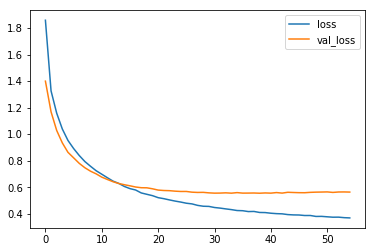

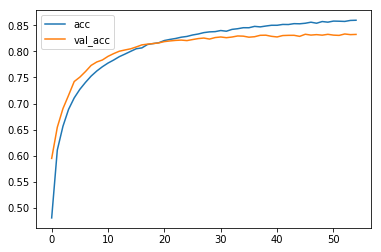

In [ ]:
plt.plot(hist.history['loss'], label = 'loss') 
plt.plot(hist.history['val_loss'], label = 'val_loss') 
plt.legend()
plt.show()


plt.plot(hist.history['acc'], label = 'acc') 
plt.plot(hist.history['val_top_1_categorical_accuracy'], label = 'val_acc') 
plt.legend()
plt.show()

## Prueba de representación de embeddings

In [ ]:
embeddings = model.layers[14].get_weights()[0]
embeddings

In [ ]:
embeddings[:,1]

array([ 0.2392255 , -0.2346982 ,  0.4903437 ,  0.25599873, -0.1441072 ,
       -0.01557353, -0.01640102,  0.27828872,  0.20984264, -0.49410602,
       -0.40164003, -0.11440374], dtype=float32)

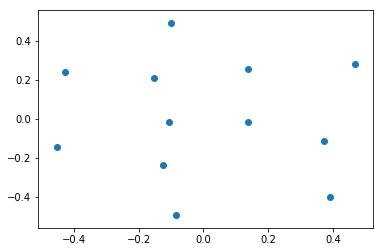

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(embeddings[:,0],embeddings[:,1]) 
plt.show()

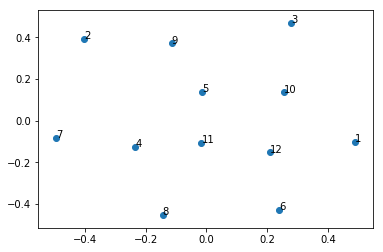

In [ ]:
y = embeddings[:,0]
z = embeddings[:,1]
n = [6, 4, 1, 10,8,5,11,3,12,7,2,9]

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

## Figura de los modelos

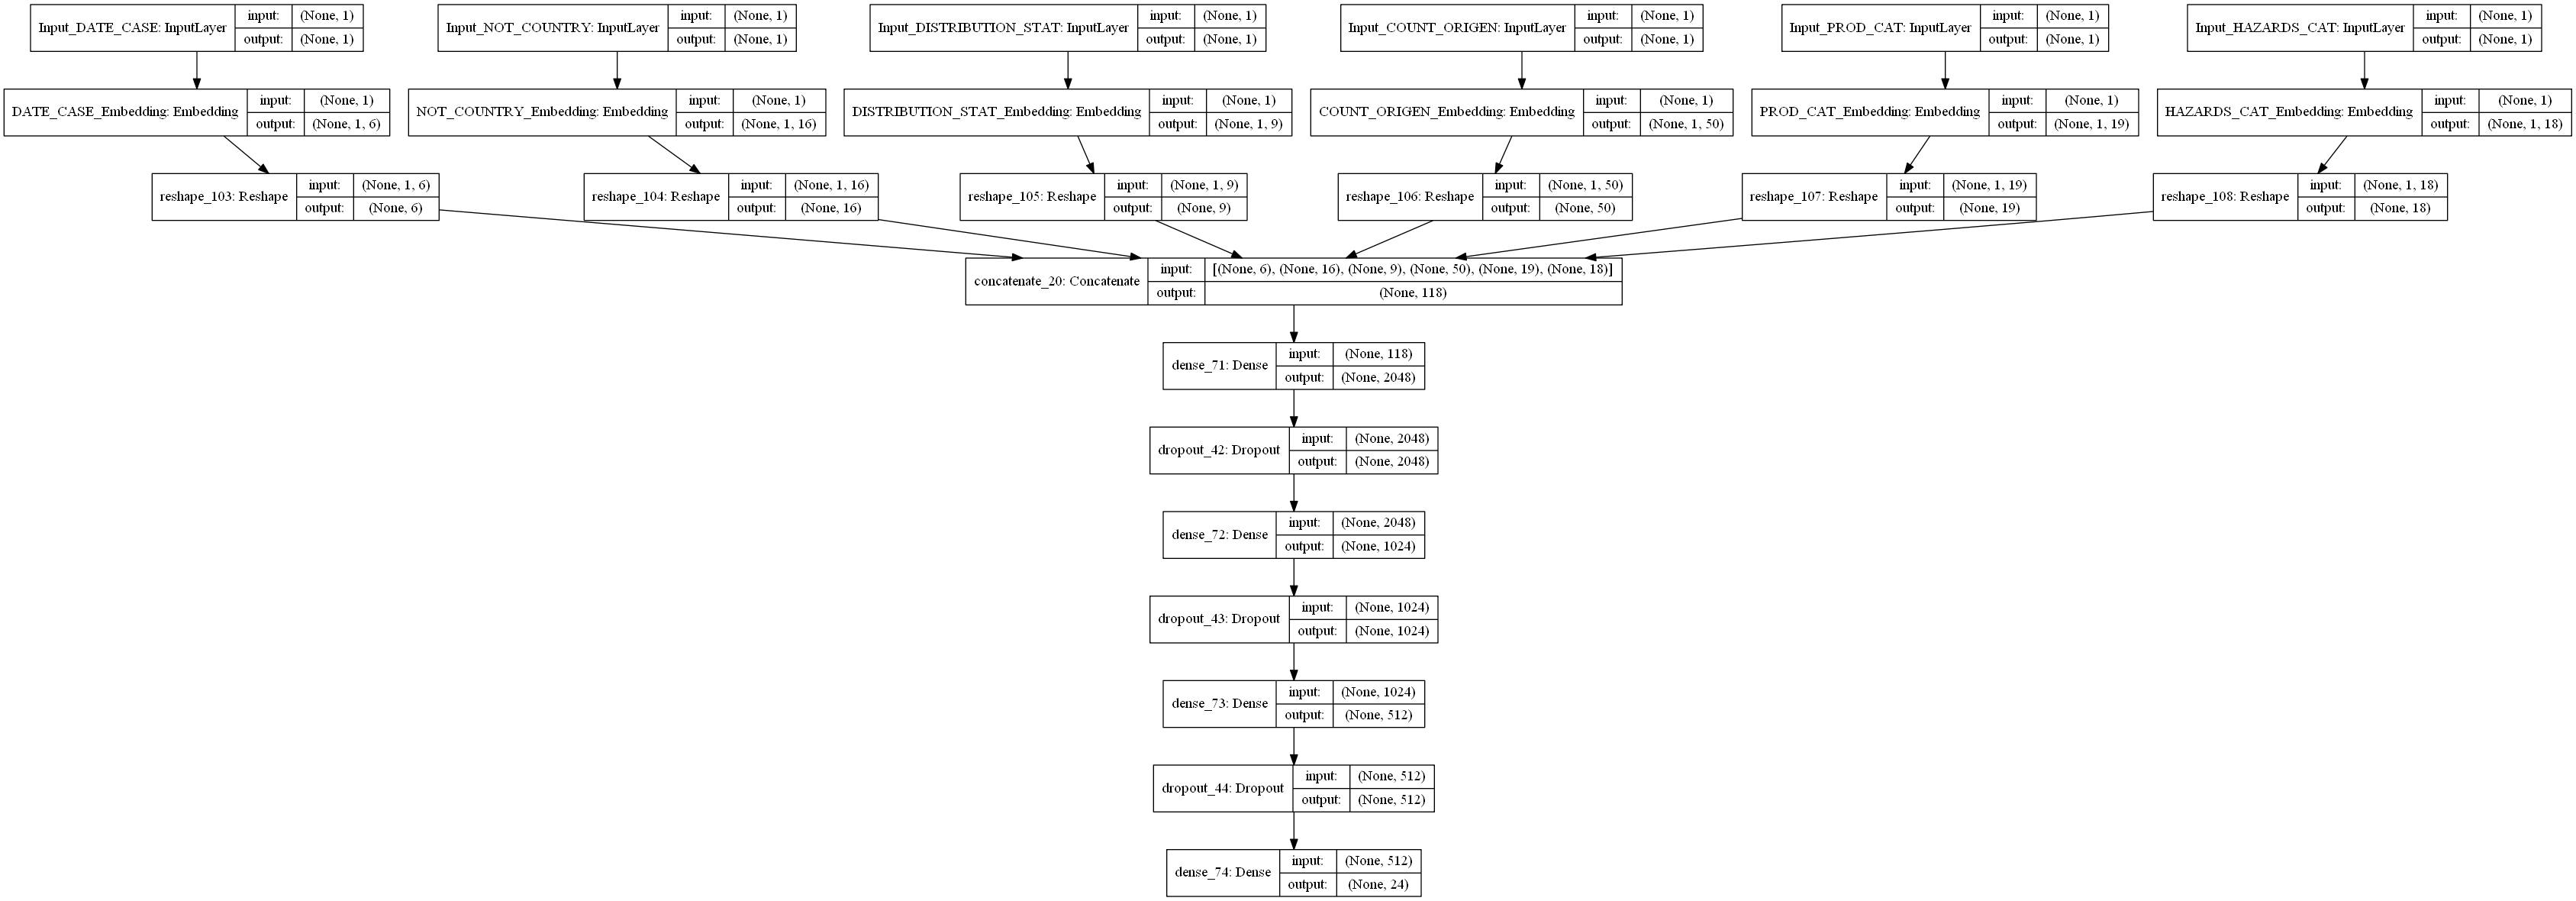

In [ ]:
plot_model(model, to_file='model3.png',show_shapes=True,show_layer_names=True)
Image(retina=True, filename='model3.png')

## Predicciones y transformaciones inversas ( conversión de la predicción numérica en la categoría predicha)

In [ ]:
prediction = model.predict(input_list_test)
prediction[0]

array([5.3615795e-24, 4.5768328e-14, 2.0483328e-20, 2.7210026e-19,
       5.5586956e-19, 2.9675704e-10, 8.5927073e-12, 3.0571820e-19,
       1.0075099e-11, 2.6107550e-06, 1.1073312e-11, 6.0050798e-22,
       6.2269985e-23, 1.4456352e-22, 8.7427961e-17, 3.3094022e-25,
       5.7479997e-13, 8.5249417e-07, 7.9353856e-19, 4.9578402e-06,
       1.0626364e-28, 2.3907197e-19, 2.5110889e-26, 2.8631649e-17,
       1.9510434e-08, 1.9792678e-15, 5.0914146e-21, 1.1527289e-09,
       9.9999154e-01, 7.1200787e-18, 2.7833156e-22, 1.9643790e-18,
       5.6017002e-17, 2.4905619e-24, 1.2678915e-19], dtype=float32)

In [ ]:
pred = np.around(prediction[12],decimals = 2)
pred

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.97, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ], dtype=float32)

In [ ]:
np.where(pred == 0.97)

(array([25], dtype=int64),)

In [ ]:
pred[25] = 1

In [ ]:
ency.inverse_transform(np.around(pred.reshape(1, -1),decimals = 3)) #Predicción

array([['meat_and_meat_products_(other_than_poultry)']], dtype=object)

In [ ]:
ency.inverse_transform(np.around(y_test[25].reshape(1, -1),decimals = 1)) #Realidad

array([['food_contact_materials']], dtype=object)

## Pruebas grid search

In [ ]:
def create_model(activation = 'relu' ):
    input_models=[]
    output_embeddings=[]

    for categorical_var in categoical_vars:
        
        cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
        input_name= 'Input_' + categorical_var.replace(" ", "")
        no_of_unique_cat  = X_train[categorical_var].nunique()
        embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
        input_model = Input(shape=(1,), name=input_name)
        output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
        output_model = Reshape(target_shape=(embedding_size,))(output_model)    
        input_models.append(input_model)
        output_embeddings.append(output_model)



    output = Concatenate()(output_embeddings)
    output = Dense(2500,activation=activation)(output)
    output= Dropout(0.5)(output)
    output = Dense(1500,activation=activation)(output)
    output= Dropout(0.4)(output)
    output = Dense(1000,activation=activation)(output)
    output= Dropout(0.3)(output)
    output = Dense(38, activation='softmax')(output)
    model = Model(inputs=input_models, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])
    return model

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=1,batch_size = 512, epochs = 1000)

In [ ]:
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation = activation)

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2)
grid_result = grid.fit(input_list_train,y_train,validation_data=(input_list_test,y_test))

# Modelo embeddings + conv (caso 2)

In [ ]:
input_models=[]
output_embeddings=[]

for categorical_var in categoical_vars:
    
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
    input_name= 'Input_' + categorical_var.replace(" ", "")
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
    input_model = Input(shape=(1,), name=input_name)
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
    input_models.append(input_model)
    output_embeddings.append(output_model)

output = Concatenate()(output_embeddings)

output = Reshape(input_shape=(100,), target_shape=(100, 1))(output)


output = Conv1D(filters=128,kernel_size=4, activation = "relu")(output)
output = Conv1D(filters=128,kernel_size=4, activation = "relu")(output)
output = BatchNormalization()(output)
output = MaxPooling1D(pool_size=2)(output)

output = Conv1D(filters=256,kernel_size=3, activation = "relu")(output)
output = Conv1D(filters=256,kernel_size=3, activation = "relu")(output)
output = BatchNormalization()(output)
output = GlobalMaxPooling1D()(output)


output = Dense(512, activation = "relu")(output)

output = Dense(256, activation = "relu")(output)

output = Dense(35, activation='softmax')(output)

model = Model(inputs=input_models, outputs=output)


model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[top_1_categorical_accuracy,top_2_categorical_accuracy,top_3_categorical_accuracy])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_DATE_CASE (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
Input_NOT_COUNTRY (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
Input_DISTRIBUTION_STAT (InputL (None, 1)            0                                            
__________________________________________________________________________________________________
Input_COUNT_ORIGEN (InputLayer) (None, 1)            0                                            
____________________________________________________________________________________________

In [ ]:
plot_model(model, to_file='model2.png',show_shapes=True,show_layer_names=True)
Image(retina=True, filename='model2.png')

In [ ]:
hist = model.fit(input_list_train,y_train,validation_data=(input_list_test,y_test) , epochs =  25, batch_size = 64, verbose= 1)


Train on 84917 samples, validate on 28306 samples
Epoch 1/25
84917/84917 [==============================] - 89s 1ms/step - loss: 1.5825 - top_1_categorical_accuracy: 0.5362 - top_2_categorical_accuracy: 0.6999 - top_3_categorical_accuracy: 0.7776 - val_loss: 1.3890 - val_top_1_categorical_accuracy: 0.5958 - val_top_2_categorical_accuracy: 0.7520 - val_top_3_categorical_accuracy: 0.8247
Epoch 2/25
84917/84917 [==============================] - 95s 1ms/step - loss: 1.2203 - top_1_categorical_accuracy: 0.6327 - top_2_categorical_accuracy: 0.7874 - top_3_categorical_accuracy: 0.8541 - val_loss: 1.1831 - val_top_1_categorical_accuracy: 0.6475 - val_top_2_categorical_accuracy: 0.7980 - val_top_3_categorical_accuracy: 0.8625
Epoch 3/25
84917/84917 [==============================] - 91s 1ms/step - loss: 1.0661 - top_1_categorical_accuracy: 0.6730 - top_2_categorical_accuracy: 0.8232 - top_3_categorical_accuracy: 0.8825 - val_loss: 1.0914 - val_top_1_categorical_accuracy: 0.6746 - val_top_2_ca

In [ ]:
model.evaluate(x = input_list_testval, y = y_val)

100/100 [==============================] - 0s 1ms/step


[0.7639038562774658, 0.77, 0.9, 0.95]

In [ ]:
plt.plot(hist.history['loss'], label = 'loss') 
plt.plot(hist.history['val_loss'], label = 'val_loss') 
plt.legend()
plt.show()


plt.plot(hist.history['categorical_accuracy'], label = 'acc') 
plt.plot(hist.history['val_categorical_accuracy'], label = 'val_acc') 
plt.legend()
plt.show()